In [87]:
import datetime
import pandas as pd
import numpy as np
import scipy.stats as sm

import seaborn as sns
%matplotlib inline
import statsmodels.formula.api as smf
sns.set_style("whitegrid")
sns.set_context("poster")

In [88]:
def pythonisShit(val, lag = 0):
    a, b = val.split('+')
    return datetime.datetime.strptime(a+b[5:], '%a %b %d %H:%M:%S %Y') - datetime.timedelta(hours = lag)

In [89]:
def parseDF(df, day, start, weeklySecs):
    df['Created_at'] = df.apply(lambda x : pythonisShit(x['created_at'], lag = 5), axis = 1)
    df.sort_values('Created_at', inplace=True, ascending=True)
    df.reset_index(drop=True, inplace=True)
    df['Sec_Elapsed'] = df.apply(lambda x : (x['Created_at'] - start).total_seconds(), axis = 1)
    df = df[df['Sec_Elapsed'] >= 0]
    pd.options.mode.chained_assignment = None  # default='warn'
    df['Week'], df['Sec_in_week'] = np.divmod(df['Sec_Elapsed'], weeklySecs)
    #df['Week'] = df['Week'] - min(df['Week'])
    return df[['Created_at', 'Sec_Elapsed', 'Week', 'Sec_in_week']]

In [90]:
def linSpace(upper, size, lower = None):
    if lower is None:
        lower = 2 - upper
    n = round((float(upper)-lower)/size, 0) + 1
    return np.linspace(lower, upper, n)

In [91]:
def main(df, day, adjustment = 0, tweets = None, timedelta = 0, brackets = None, ci = 1.2, ignores = []):
    if day == 'Tuesday':
        start = datetime.datetime.strptime('11/07/2017 12:00', "%m/%d/%Y %H:%M")
    elif day == 'Wednesday':
        start = datetime.datetime.strptime('11/08/2017 12:00', "%m/%d/%Y %H:%M")
    elif day == 'Thursday':
        start = datetime.datetime.strptime('12/28/2017 12:00', "%m/%d/%Y %H:%M")
    elif day == "Friday":
        start = datetime.datetime.strptime('11/10/2017 12:00', "%m/%d/%Y %H:%M")
    else:
        raise ValueError('StartDate not Properly Specified')
    weeklySecs = 60*60*24*7
    df = parseDF(df, day, start, weeklySecs)
    curr = int((datetime.datetime.now() - start + datetime.timedelta(hours = timedelta)).total_seconds())
    week, now = divmod(curr, weeklySecs)
    
    ignores_ = [] 
    if min(df['Week']):
        ignores_ = range(int(min(df['Week'])))

    if len(ignores):
        for i in ignores:
            ignores_.append(divmod((i - start).total_seconds(), weeklySecs)[0])
    pastData = []
    
    currTimes = [0]+ [int(t) for t in df[df['Week'] == week]['Sec_in_week'].values] + [now]
    currCounts = list(np.array(range(len(currTimes)))+adjustment)
    if tweets is not None:
        currCounts[-1] = tweets
    else:
        currCounts[-1] -= 1
        tweets = currCounts[-1]
    pastData.append(zip(currTimes, currCounts))
    
    for i in xrange(week):
        if i not in ignores_:
            times = [0]+ [int(t) for t in df[df['Week'] == i]['Sec_in_week'].values] + [weeklySecs]
            counts = range(len(times))
            counts[-1] -= 1
            pastData.append(zip(times, counts))
            print counts[-1],
    print
    sns.set_palette(sns.cubehelix_palette(len(pastData), rot = 3))
    
    
    timeLeft = weeklySecs-now
    if timeLeft > 6*60:
        step = 60*60*12
    else:
        step = 60*30
        
    times = np.linspace(now, weeklySecs, 2 + timeLeft/step)[1:]
    
    max_ = times[-1]

    bounds = [.025, .25, .5, .75, .975]
    m = len(bounds)
    toPlot1 = [(now, tweets)]*m
    #toPlot2 = [(now, tweets)]*m
    for t in times:
        dataToLearn = list(df[(df['Sec_in_week'] <= t) & (df['Sec_in_week'] > now) & (~df['Week'].isin(ignores_))]['Week'].value_counts().values)
        dataToLearn2 = df[(df['Sec_in_week'] <= t) & (df['Sec_in_week'] > now) & (~df['Week'].isin(ignores_))]['Week'].value_counts()
        dataToLearn3 = []
        for i in xrange(week):
            if i in ignores_:
                continue
            if i in dataToLearn2:
                dataToLearn3 += (int(i)+1)*[dataToLearn2[i]]
            else:
                dataToLearn3 += (int(i)+1)*[0]
        expected_Len = week - len(ignores)
        while len(dataToLearn) < expected_Len:
            dataToLearn.append(0)
        shape,  loc,  scale  = sm.lognorm.fit(dataToLearn3, floc = 0)
#        shape2, loc2, scale2 = sm.gamma.fit(dataToLearn)
        for b in bounds:
            toPlot1.append((t, tweets+sm.lognorm.ppf(b, s = shape, loc = loc, scale = scale)))
            #toPlot2.append((t, tweets+sm.gamma.ppf(b, a = shape2, loc = loc2, scale = scale2)))
        if t == max_ and brackets:
            calcs = linSpace(ci, .025)
            bracketExtremes = {bra : [np.inf, 0., None, None] for bra in brackets[1:]}
            for c in calcs:
                shape2,  loc2,  scale2  = sm.lognorm.fit(np.array(dataToLearn3)*c, floc = 0)
                probs2 = [sm.lognorm.cdf(bra-tweets, s = shape2, loc = loc2, scale = scale2) for bra in brackets]
                for i, p in enumerate(probs2):
                    if i:
                        prob = round((probs2[i] - probs2[i-1])*100,2)
                        if prob > bracketExtremes[brackets[i]][1]:
                            bracketExtremes[brackets[i]][1] = prob
                            bracketExtremes[brackets[i]][3] = c
                        if prob < bracketExtremes[brackets[i]][0]:
                            bracketExtremes[brackets[i]][2] = c
                            bracketExtremes[brackets[i]][0] = prob   
            probs1 = [sm.lognorm.cdf(bra-tweets, s = shape, loc = loc, scale = scale) for bra in brackets]
            #probs2 = [sm.gamma.cdf(bra-tweets, a = shape2, loc = loc2, scale = scale2) for bra in brackets]

    if brackets:
        for i, p in enumerate(probs1):
            if i:
                print "{}-{} Bracket: {} [{}({})-{}({})]".format(brackets[i-1], brackets[i]-1, round((probs1[i] - probs1[i-1])*100,2),
                                                         bracketExtremes[brackets[i]][0], bracketExtremes[brackets[i]][2],
                                                         bracketExtremes[brackets[i]][1], bracketExtremes[brackets[i]][3])
        #for i, p in enumerate(probs2):
        #    if i:
        #        print "{}-{} Bracket: {}".format(brackets[i-1], brackets[i]-1, round((probs2[i] - probs2[i-1])*100,2))
            
    plt.figure(figsize=(20,15))

    print start+datetime.timedelta(seconds = curr), 'with', tweets, 'tweets'
    for p, v in zip(bounds, zip(*toPlot1[-m:])[1]):
        print p,
        for _ in xrange(6-len(str(p))):
            print '',
        print round(v, 2)       
        
    for i, p in enumerate(pastData):
        a, b = zip(*p)
        x = plt.plot(a, b)
        if not i:
            col = x[0].get_color()

    for i in xrange(m):
        plt.plot(*zip(*toPlot1[i::m]), linestyle = 'dashed', color = '#17becf')
        #plt.plot(*zip(*toPlot2[i::m]), linestyle = 'dashed', color = 'red')
    
    plt.xlim(-2000, weeklySecs+2000)

50 34 53 45 43 54 46 58 49 33 30 55 52 45 45 32 36 41 44 66 62 48


/Users/cpenalobel/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  """


0-39 Bracket: 0.0 [0.0(0.7)-0.0(None)]
40-44 Bracket: 0.0 [0.0(0.7)-0.0(None)]
45-49 Bracket: 95.74 [87.16(1.3)-99.41(0.7)]
50-54 Bracket: 4.21 [0.59(0.7)-12.47(1.3)]
55-59 Bracket: 0.05 [0.0(0.7)-0.35(1.3)]
60-64 Bracket: 0.0 [0.0(0.7)-0.02(1.3)]
65-inf Bracket: 0.0 [0.0(0.7)-0.0(None)]
2018-05-09 07:27:41 with 45 tweets
0.025  45.96
0.25   46.71
0.5    47.32
0.75   48.13
0.975  50.56


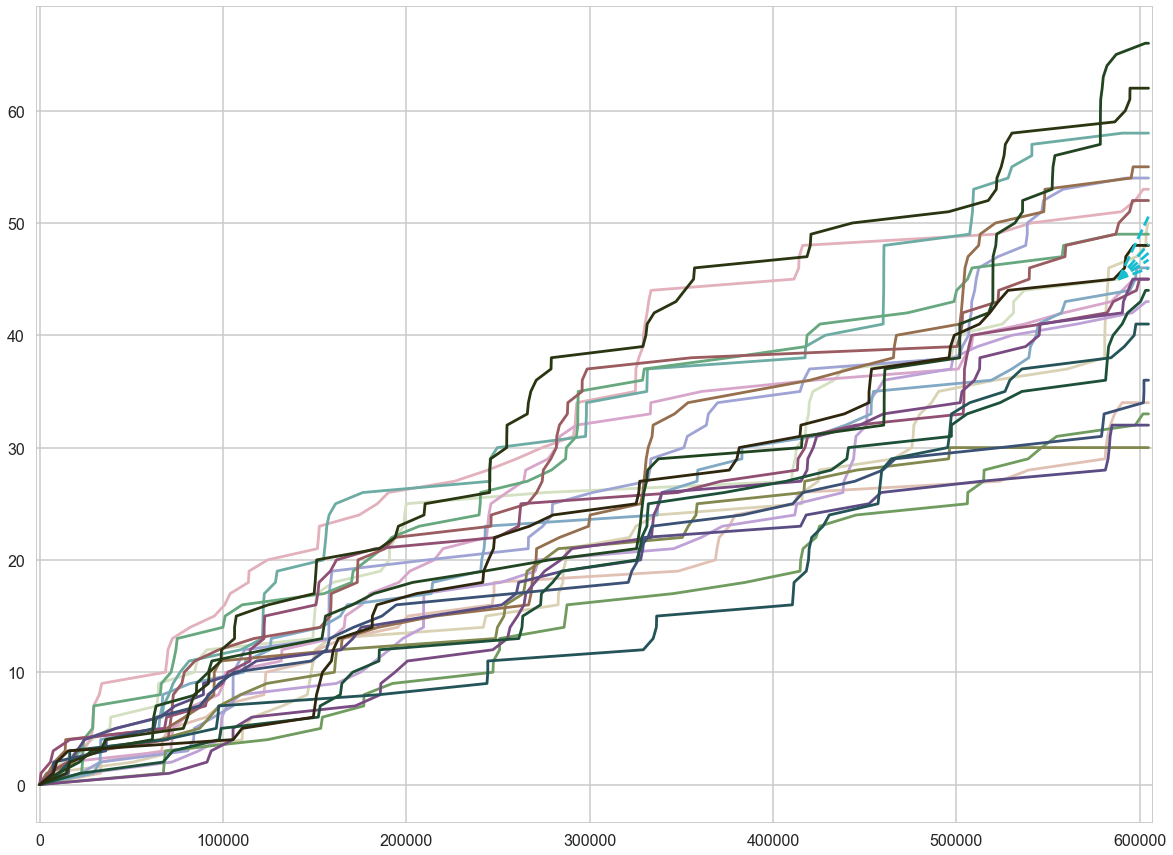

In [107]:
rdt = pd.read_csv('realdonaldtrump.csv')
main(rdt, 'Wednesday', tweets = 45, brackets = [0,40,45,50,55,60,65,np.inf], ci = 1.3, ignores = 
    [datetime.datetime.strptime('12/25/2017 11:00', "%m/%d/%Y %H:%M"), 
    datetime.datetime.strptime('11/23/2017 11:00', "%m/%d/%Y %H:%M"),
    datetime.datetime.strptime('1/30/2018 11:00', "%m/%d/%Y %H:%M")])

40 112 74 86 72 69 41 66 51 84 53 93 54 38
0-39 Bracket: 0.0
40-49 Bracket: 0.02
50-59 Bracket: 6.43
60-69 Bracket: 28.47
70-79 Bracket: 30.8
80-89 Bracket: 18.78
90-inf Bracket: 15.5
2018-04-15 15:27:45 with 41 tweets
0.025  57.11
0.25   67.05
0.5    74.52
0.75   84.14
0.975  110.77


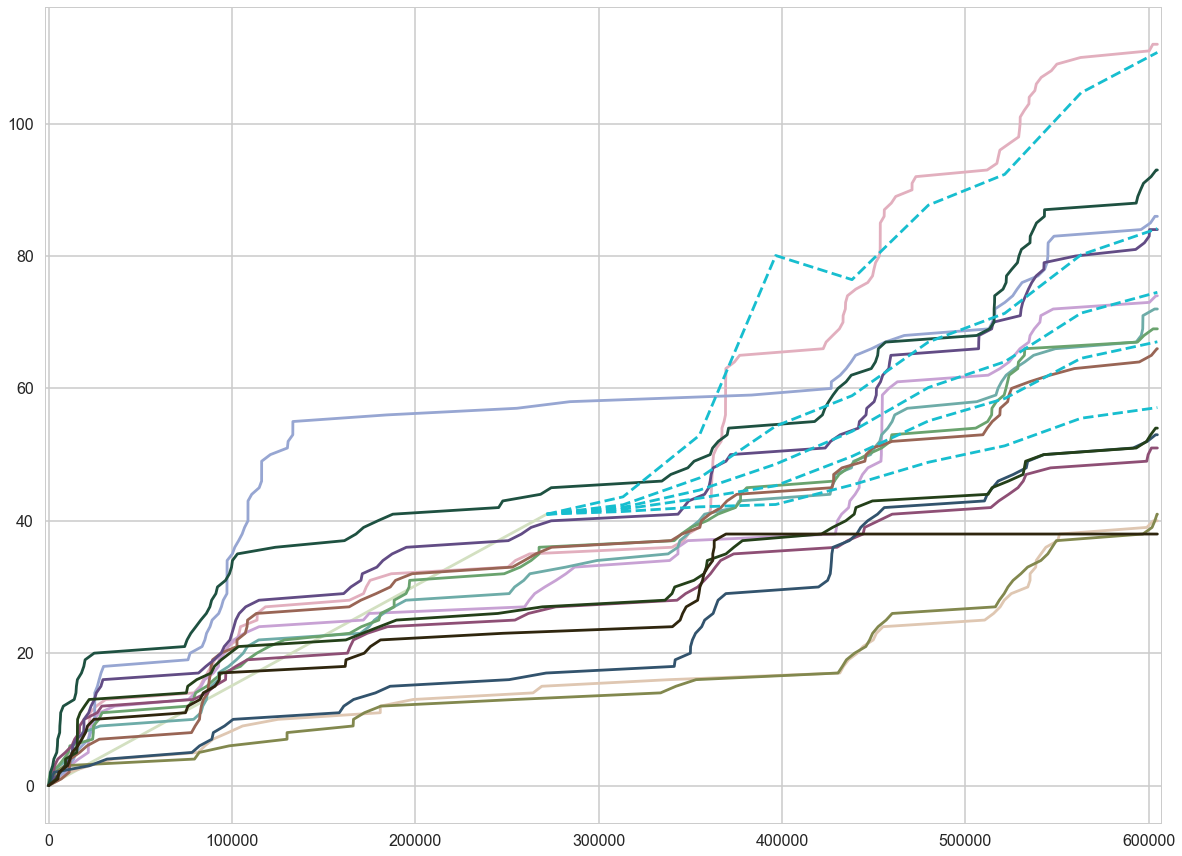

In [6]:
wh = pd.read_csv('whitehouse.csv')
main(wh, 'Thursday', tweets =41, brackets = [0,40,50,60,70,80,90,np.inf],
     ignores = [datetime.datetime.strptime('1/30/2018 11:00', "%m/%d/%Y %H:%M")])

70 41 41 24 71 29 53 43 55 24 18 15 32 13 31 23 35 21 21 64 34 36


/Users/cpenalobel/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  """


0-24 Bracket: 0.0 [0.0(0.8)-0.0(None)]
25-29 Bracket: 0.0 [0.0(0.8)-0.0(None)]
30-34 Bracket: 0.35 [0.1(1.2)-1.29(0.8)]
35-39 Bracket: 15.72 [8.35(1.2)-28.79(0.8)]
40-44 Bracket: 31.47 [24.35(1.2)-35.75(0.8)]
45-49 Bracket: 24.4 [19.5(0.8)-25.21(1.125)]
50-inf Bracket: 28.06 [14.67(0.8)-42.18(1.2)]
2018-05-08 20:30:24 with 31 tweets
0.025  36.68
0.25   41.46
0.5    45.42
0.75   50.86
0.975  67.58


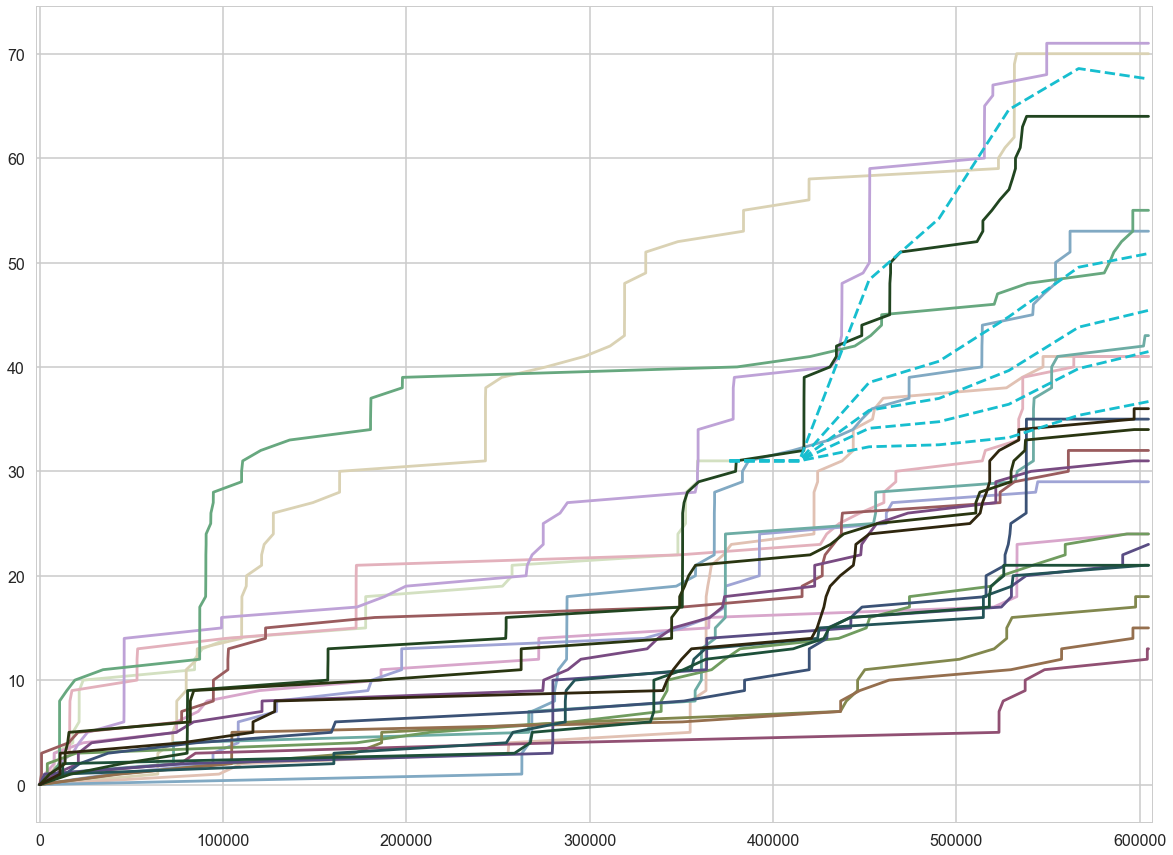

In [101]:
potus = pd.read_csv('potus.csv')
main(potus, 'Friday', tweets = 31, brackets = [0,25,30,35,40,45,50,np.inf], ignores = 
    [datetime.datetime.strptime('12/25/2017 11:00', "%m/%d/%Y %H:%M"), 
    datetime.datetime.strptime('11/23/2017 11:00', "%m/%d/%Y %H:%M"),
     datetime.datetime.strptime('1/30/2018 11:00', "%m/%d/%Y %H:%M")])

53 42 61 42 53 34 58 31 48 46 31 47 35 54 40 34 39 12 26 63 49 51


/Users/cpenalobel/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  """


0-34 Bracket: 0.0 [0.0(0.8)-0.0(None)]
35-39 Bracket: 0.0 [0.0(0.8)-0.0(None)]
40-44 Bracket: 0.69 [0.19(1.2)-2.69(0.8)]
45-49 Bracket: 14.91 [7.19(1.2)-29.0(0.8)]
50-54 Bracket: 29.89 [21.73(1.2)-34.64(0.8)]
55-59 Bracket: 24.99 [19.51(0.8)-25.54(1.1)]
60-inf Bracket: 29.52 [14.16(0.8)-45.96(1.2)]
2018-05-09 07:22:38 with 39 tweets
0.025  46.4
0.25   51.66
0.5    55.78
0.75   61.23
0.975  77.01


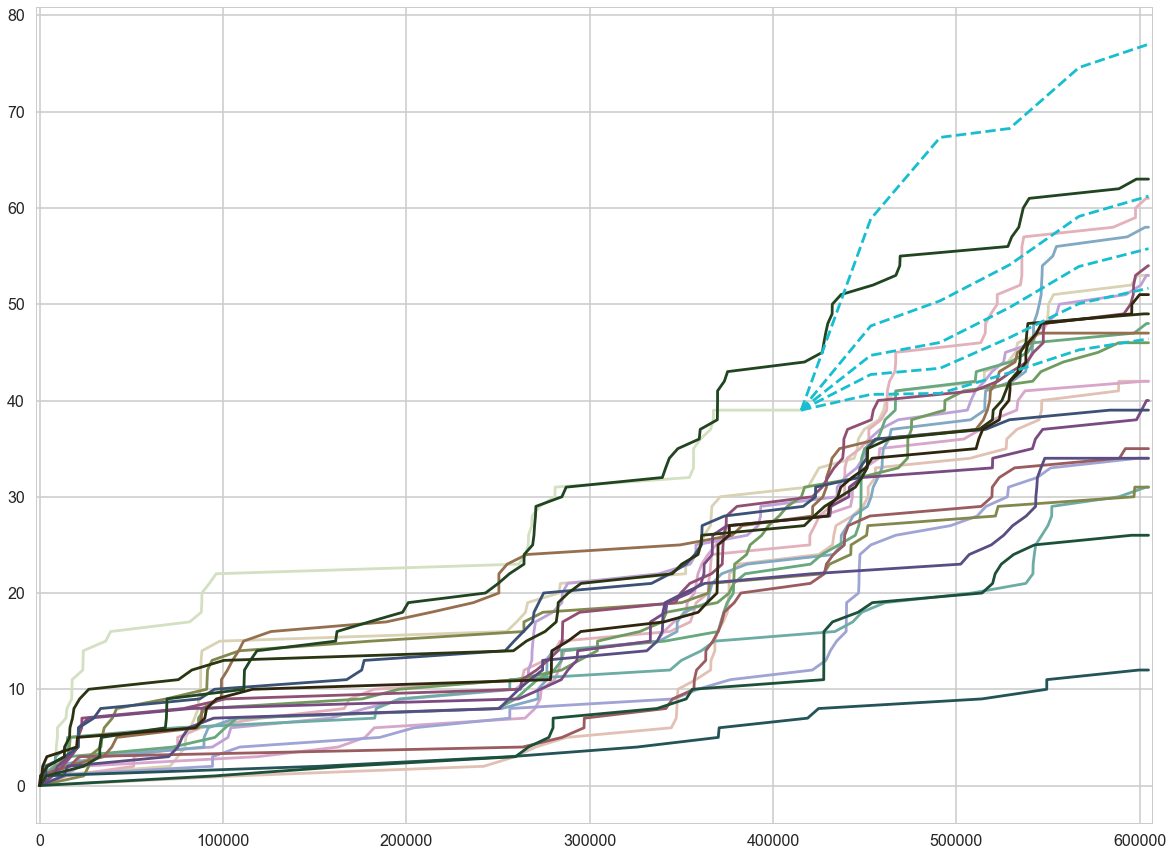

In [106]:
pence = pd.read_csv('vp.csv')
main(pence, 'Friday', tweets = 39, brackets = [0,35,40,45,50,55,60,np.inf], ignores = 
    [datetime.datetime.strptime('12/25/2017 11:00', "%m/%d/%Y %H:%M"), 
    datetime.datetime.strptime('11/23/2017 11:00', "%m/%d/%Y %H:%M"),
    datetime.datetime.strptime('1/23/2018 11:00', "%m/%d/%Y %H:%M")])